## Import Packages

In [1]:
from utils import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, TimeDistributed, Permute
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import datetime

Device mapping: no known devices.


## Load Dataset

### load and preprocess data

In [2]:
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=True)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=True, sample_size=800)
x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

Training data shape: (7616, 22, 400) Training target shape: (7616,)
Testing data shape: (443, 22, 400) Testing target shape: (443,)
Training data shape: (7616, 400, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 400, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 400, 1, 22) Testing target shape: (443, 4)


## CNN + LSTM

In [3]:
dropout = 0.6

# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(15,1), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(dropout))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(dropout))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(dropout))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible

hybrid_cnn_lstm_model.add(LSTM(10, dropout=dropout, recurrent_dropout=0.1))
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        8275      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 134, 1, 25)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 134, 1, 25)       100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 134, 1, 50)        18800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 1, 50)        0

In [4]:
# Model parameters
learning_rate = 0.001
epochs = 100
hybrid_cnn_lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=1e-4)



Compile and train the model

In [5]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'],
                )

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train_aug,
             y_train_aug,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_aug, y_valid_aug), verbose=True,
             )


Epoch 1/100


2024-03-13 20:22:49.920950: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


119/119 [==============================] - 6s 43ms/step - loss: 1.3947 - accuracy: 0.2732 - val_loss: 1.3732 - val_accuracy: 0.2820
Epoch 2/100
119/119 [==============================] - 5s 43ms/step - loss: 1.3729 - accuracy: 0.3011 - val_loss: 1.3295 - val_accuracy: 0.3531
Epoch 3/100
119/119 [==============================] - 5s 46ms/step - loss: 1.3527 - accuracy: 0.3353 - val_loss: 1.2899 - val_accuracy: 0.3637
Epoch 4/100
119/119 [==============================] - 5s 43ms/step - loss: 1.2922 - accuracy: 0.4014 - val_loss: 1.3101 - val_accuracy: 0.3697
Epoch 5/100
119/119 [==============================] - 5s 46ms/step - loss: 1.2358 - accuracy: 0.4364 - val_loss: 1.2262 - val_accuracy: 0.4360
Epoch 6/100
119/119 [==============================] - 5s 44ms/step - loss: 1.1978 - accuracy: 0.4598 - val_loss: 1.1762 - val_accuracy: 0.4609
Epoch 7/100
119/119 [==============================] - 5s 42ms/step - loss: 1.1625 - accuracy: 0.4870 - val_loss: 1.1842 - val_accuracy: 0.4502
Epoc

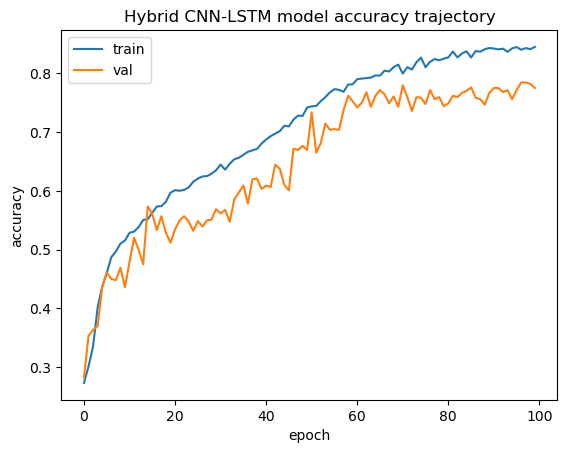

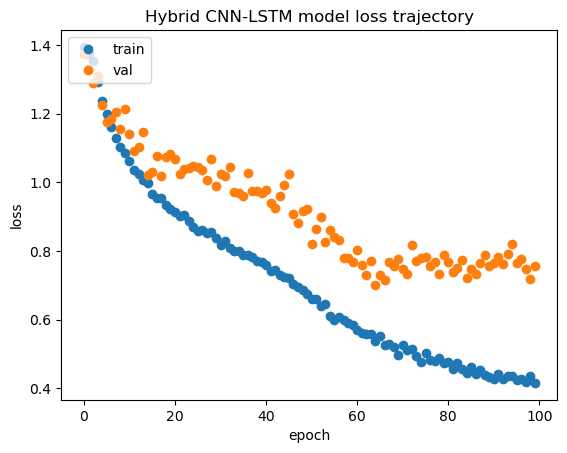

In [6]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train' , 'val'], loc='upper left')
plt.show()

### Test on all subjects

In [7]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_aug, y_test_aug, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7200902700424194


### Test on subject 1

In [26]:
X_train_subject, y_train_subject, X_test_subject, y_test_subject = init_data(subject=1, verbose=True)
X_train_aug_subject, y_train_aug_subject, X_test_aug_subject, y_test_aug_subject, X_valid_aug_subject, y_valid_aug_subject= preprocess_data(X_train_subject, y_train_subject, X_test_subject, y_test_subject, verbose=True, sample_size=800)
_, _, _, _, x_test_aug_subject, y_test_aug_subject = load_data(X_train_aug_subject, y_train_aug_subject, X_valid_aug_subject, y_valid_aug_subject, X_test_aug_subject, y_test_aug_subject, verbose=True)

Training Subject 1: Training data shape: (236, 22, 1000) Testing data shape: (236,)
Testing Subject 1: Training data shape: (50, 22, 1000) Testing data shape: (50,)
Training data shape: (852, 22, 400) Training target shape: (852,)
Testing data shape: (50, 22, 400) Testing target shape: (50,)
Training data shape: (852, 400, 1, 22) Training target shape: (852, 4)
Validation data shape: (92, 400, 1, 22) Validation target shape: (92, 4)
Testing data shape: (50, 400, 1, 22) Testing target shape: (50, 4)


In [28]:
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(X_test_aug_subject, y_test_aug_subject, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model on subject 0:',hybrid_cnn_lstm_score[1])

2024-03-13 21:03:40.538195: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:757 : INVALID_ARGUMENT: convolution input must be 4-dimensional: [32,22,400]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/conv2d/BiasAdd' defined at (most recent call last):
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
      self.io_loop.start()
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
      await result
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/5d/0mx264y53jbbh8g1s0g8f3340000gn/T/ipykernel_8551/2756109254.py", line 1, in <module>
      hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(X_test_subject, y_test_subject, verbose=0)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1756, in test_step
      y_pred = self(x, training=False)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 304, in call
      outputs = tf.nn.bias_add(
Node: 'sequential/conv2d/BiasAdd'
convolution input must be 4-dimensional: [32,22,400]
	 [[{{node sequential/conv2d/BiasAdd}}]] [Op:__inference_test_function_62497]

## Train based on Subjects